In [1]:
import pandas as pd
import numpy as np
import os
import time
import json
import math
import typing as T
import requests

In [2]:
df = pd.read_csv('finals_ltp.csv')
df.head(10)

,AUBANK,AXISBANK,BANKBARODA,CANBK,FEDERALBNK,HDFCBANK,ICICIBANK,IDFCFIRSTB,INDUSINDBK,KOTAKBANK,PNB,SBIN
0,565.45,1017.05,198.10,81.25,177.81,1739.80,1210.50,58.39,978.95,1905.55,87.80,690.15
1,565.00,1014.05,198.02,81.09,178.54,1738.30,1213.10,58.35,974.10,1900.65,88.00,689.75
2,565.85,1014.50,198.13,81.39,178.90,1742.35,1212.00,58.40,970.55,1899.50,88.54,690.85
3,563.45,1011.95,198.00,81.36,178.27,1740.40,1212.85,58.38,972.50,1901.30,88.42,689.75
4,562.70,1011.55,198.25,81.55,178.35,1738.20,1211.35,58.39,976.00,1899.50,88.45,690.90
5,563.15,1011.55,198.12,81.21,178.07,1740.65,1210.85,58.30,974.45,1898.30,88.35,690.70
6,561.00,1009.30,197.30,81.01,177.53,1737.25,1210.95,58.05,972.35,1897.85,87.99,689.70
7,561.30,1010.10,196.79,80.68,177.09,1736.00,1211.70,57.93,971.50,1897.30,87.80,689.50
8,562.75,1009.10,196.84,80.76,177.17,1734.85,1210.80,58.07,973.90,1899.05,87.94,689.85
9,561.15,1006.40,196.44,80.51,176.74,1732.85,1208.40,57.83,971.15,1899.00,87.79,688.40


In [3]:
df = df.reset_index().rename(columns={'index': 'time'})

In [4]:
df.head()

,time,AUBANK,AXISBANK,BANKBARODA,CANBK,FEDERALBNK,HDFCBANK,ICICIBANK,IDFCFIRSTB,INDUSINDBK,KOTAKBANK,PNB,SBIN
0,0,565.45,1017.05,198.10,81.25,177.81,1739.80,1210.50,58.39,978.95,1905.55,87.80,690.15
1,1,565.00,1014.05,198.02,81.09,178.54,1738.30,1213.10,58.35,974.10,1900.65,88.00,689.75
2,2,565.85,1014.50,198.13,81.39,178.90,1742.35,1212.00,58.40,970.55,1899.50,88.54,690.85
3,3,563.45,1011.95,198.00,81.36,178.27,1740.40,1212.85,58.38,972.50,1901.30,88.42,689.75
4,4,562.70,1011.55,198.25,81.55,178.35,1738.20,1211.35,58.39,976.00,1899.50,88.45,690.90


In [5]:
BN_OFFICIAL_PATH = None
WEIGHTS_CSV = "weights.csv"
OUT_PATH = "cm_index_mcap_weighted.csv"

In [6]:
finals_df = df.copy()
# Use only numeric columns for tickers; drop any non-numeric helper cols except timestamp-like
maybe_ts_cols = [c for c in finals_df.columns if str(c).lower() in ("timestamp","time","datetime")]
for c in finals_df.columns:
    if c not in maybe_ts_cols:
        finals_df[c] = pd.to_numeric(finals_df[c], errors="coerce")

# Pull out timestamp if present
timestamp = None
for c in maybe_ts_cols:
    if c in finals_df.columns:
        timestamp = finals_df.pop(c)
        break
if timestamp is None:
    timestamp = pd.RangeIndex(1, len(finals_df)+1, name="timestamp")

# Normalize ticker headers
cols = [str(c).strip().strip().upper() for c in finals_df.columns]
finals_df.columns = cols

# Remove any columns that are fully NaN 
finals_df = finals_df.dropna(axis=1, how="all")
if finals_df.shape[1] == 0:
    raise ValueError("No usable LTP columns found in finals_df after cleaning.")

In [7]:
BN_OFFICIAL_PATH = None
WEIGHTS_CSV = "weights.csv"
OUT_PATH = "cm_index_mcap_weighted.csv"

def load_weights_csv(path: str) -> pd.Series:
    wdf = pd.read_csv(path)
    cols_lower = {c.lower(): c for c in wdf.columns}
    sym_col = cols_lower.get("symbol")
    w_col   = cols_lower.get("weight")
    if not sym_col or not w_col:
        raise ValueError("weights.csv must have columns: symbol, weight (percent).")
    s = pd.Series(wdf[w_col].values, index=wdf[sym_col].astype(str).str.upper())
    s = s.astype(float) / 100.0
    s = s[s > 0]
    s = s / s.sum()
    return s

# Fallback weights (fraction, NOT percent) — replace with your latest if needed
fallback_weights = {
    "HDFCBANK": 0.2710,
    "ICICIBANK": 0.2305,
    "SBIN": 0.1230,
    "KOTAKBANK": 0.1100,
    "AXISBANK": 0.0910,
    "INDUSINDBK": 0.0500,
    "PNB": 0.0310,
    "BANKBARODA": 0.0300,
    "FEDERALBNK": 0.0220,
    "IDFCFIRSTB": 0.0210,
    "CANBK": 0.0200,
    "AUBANK": 0.0105,
}

if os.path.exists(WEIGHTS_CSV):
    weights = load_weights_csv(WEIGHTS_CSV)
else:
    print(f"[INFO] {WEIGHTS_CSV} not found. Using embedded fallback weights.")
    weights = pd.Series(fallback_weights, dtype="float64")
    weights = weights / weights.sum()  # ensure sum to 1

# --------- Align symbols and re-normalize weights ----------
tickers = finals_df.columns.astype(str)
common = weights.index.intersection(tickers)
if len(common) == 0:
    raise ValueError("No overlap between weights symbols and finals_df columns.\n"
                     f"weights symbols: {list(weights.index)}\n"
                     f"finals_df columns: {list(tickers)}")

if len(common) < len(weights):
    missing_in_df = list(weights.index.difference(tickers))
    print(f"[WARN] Dropping weighted symbols absent in finals_df: {missing_in_df}")

weights = weights.loc[common]
weights = weights / weights.sum()  

# Also reduce finals_df to common tickers
ltp_mat = finals_df[common].copy()

# Safety: forward-fill single-minute gaps
ltp_mat = ltp_mat.ffill(limit=1)

[INFO] weights.csv not found. Using embedded fallback weights.


In [8]:

# Raw cm = sum_i w_i * Price_i(t)
raw_index = (ltp_mat.values * weights.values).sum(axis=1)
raw_index = pd.Series(raw_index, index=ltp_mat.index, name="raw_mcap_wtd")


In [9]:
raw_index.shape

(27679,)

In [10]:
bn_official = pd.read_csv('bn_official.csv')
bn_official = bn_official['ltp']
bn_official.head()

0    48478.60
1    48454.05
2    48486.45
3    48475.75
4    48449.30
Name: ltp, dtype: float64

In [11]:
n = min(len(raw_index), len(bn_official))
raw_index   = raw_index.iloc[:n].reset_index(drop=True)
bn_official = bn_official.iloc[:n].reset_index(drop=True)

# scale factor (divisor surrogate) at the first minute
denom = float(raw_index.iloc[0]) if raw_index.iloc[0] != 0 else 1.0
alpha = float(bn_official.iloc[0]) / denom

cm_index = (alpha * raw_index).rename("bn_constructed_index")

out = pd.DataFrame({
    "timestamp": np.arange(1, len(cm_index)+1),
    "bn_index": bn_official,
    "bn_constructed_index": cm_index
})
out.to_csv(OUT_PATH, index=False)
print(f"[OK] Wrote {OUT_PATH}")

[OK] Wrote cm_index_mcap_weighted.csv


In [12]:
out.head(10)

,timestamp,bn_index,bn_constructed_index
0,1,48478.60,48478.600000
1,2,48454.05,48442.485750
2,3,48486.45,48472.996262
3,4,48475.75,48454.851942
4,5,48449.30,48420.593162
5,6,48441.45,48432.532512
6,7,48366.15,48373.931867
7,8,48342.75,48363.596338
8,9,48348.75,48354.478122
9,10,48263.50,48285.637471


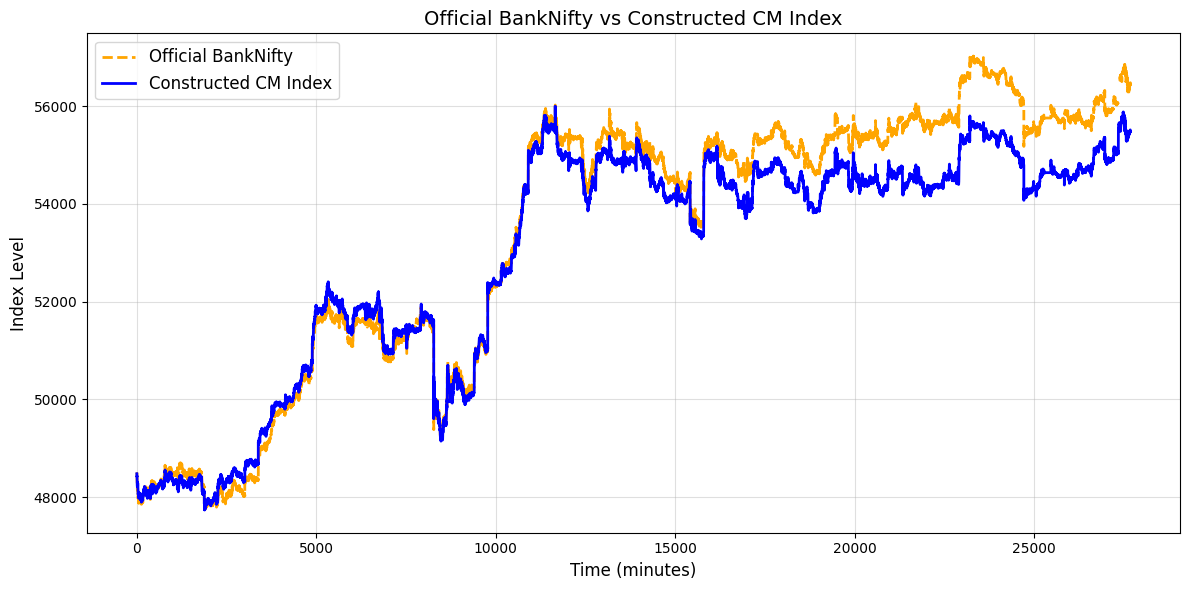

In [13]:
import matplotlib.pyplot as plt

out["bn_index"] = pd.to_numeric(out["bn_index"], errors="coerce")
out["bn_constructed_index"] = pd.to_numeric(out["bn_constructed_index"], errors="coerce")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(out["timestamp"], out["bn_index"], label="Official BankNifty", color="orange", linewidth=2, linestyle="--")
plt.plot(out["timestamp"], out["bn_constructed_index"], label="Constructed CM Index", color="blue", linewidth=2)

plt.title("Official BankNifty vs Constructed CM Index", fontsize=14)
plt.xlabel("Time (minutes)", fontsize=12)
plt.ylabel("Index Level", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
import numpy as np

# Load the file that contains both official and constructed indices
df1 = pd.read_csv('cm_index_mcap_weighted.csv')  
df1 = df1.dropna(subset=["bn_index", "bn_constructed_index"])

# Compute log returns (more stable for financial data)
df1["ret_real"] = np.log(df1["bn_index"] / df1["bn_index"].shift(1))
df1["ret_constructed"] = np.log(df1["bn_constructed_index"] / df1["bn_constructed_index"].shift(1))

# Drop first NaN row
df1 = df1.dropna()

# ----- Compute metrics -----
def calc_metrics(series):
    mean_ret = series.mean()
    std_ret = series.std()
    total_ret = (np.exp(series.sum()) - 1) * 100   # total % return over the period
    sharpe = mean_ret / std_ret if std_ret != 0 else np.nan
    return total_ret, std_ret, sharpe

total_real, vol_real, sharpe_real = calc_metrics(df1["ret_real"])
total_cm, vol_cm, sharpe_cm = calc_metrics(df1["ret_constructed"])

# ----- Print summary -----
print("📈 PERFORMANCE COMPARISON (log-returns)")
print(f"{'Metric':<20}{'Official BN':>15}{'Constructed CM':>20}")
print("-" * 55)
print(f"{'Total Return (%)':<20}{total_real:>15.2f}{total_cm:>20.2f}")
print(f"{'Volatility (std)':<20}{vol_real:>15.5f}{vol_cm:>20.5f}")
print(f"{'Sharpe Ratio':<20}{sharpe_real:>15.3f}{sharpe_cm:>20.3f}")

# Optional: correlation check
corr = df1["ret_real"].corr(df1["ret_constructed"])
print(f"\nCorrelation of returns: {corr:.4f}")


📈 PERFORMANCE COMPARISON (log-returns)
Metric                  Official BN      Constructed CM
-------------------------------------------------------
Total Return (%)              16.45               14.44
Volatility (std)            0.00056             0.00056
Sharpe Ratio                  0.010               0.009

Correlation of returns: 0.9549


In [15]:
out.tail(20)

,timestamp,bn_index,bn_constructed_index
27659,27660,56407.15,55458.919446
27660,27661,56427.15,55473.203319
27661,27662,56446.85,55465.718022
27662,27663,56440.65,55470.418508
27663,27664,56417.35,55465.273520
27664,27665,56418.50,55469.459066
27665,27666,56441.10,55482.646032
27666,27667,56425.45,55485.967256
27667,27668,56420.40,55460.925626
27668,27669,56424.60,55468.251585


In [16]:
import os
import numpy as np
import pandas as pd

CALIBRATION_FRACTION = 0.15         # use first 15% of data as calibration window
OUT_PATH = "cm_index_te_min.csv"
# ---------------------------------------------

# 1) Load finals_df (LTPs)
finals_df = df.copy()
# keep only numeric columns (tickers); keep timestamp if present
maybe_ts = None
for c in list(finals_df.columns):
    if str(c).lower() in ("timestamp","time","datetime"):
        maybe_ts = c
    else:
        finals_df[c] = pd.to_numeric(finals_df[c], errors="coerce")

timestamp = finals_df.pop(maybe_ts) if maybe_ts in finals_df.columns else pd.RangeIndex(1, len(finals_df)+1, name="timestamp")
# Normalize ticker headers
finals_df.columns = [str(c).strip().upper() for c in finals_df.columns]
finals_df = finals_df.dropna(axis=1, how="all")
X = finals_df.values  # shape (T, N)
tickers = list(finals_df.columns)

T_total, N = X.shape

In [17]:
# 2) load official index
df_bn = bn_official.copy()
# pick the first numeric column as bn_index 
# Check if df_bn is a Series (from previous steps) 
if isinstance(df_bn, pd.Series):
    y = pd.to_numeric(df_bn, errors="coerce")
elif "ltp" in df_bn.columns:
    y = pd.to_numeric(df_bn["ltp"], errors="coerce")
else:
    num_cols = [c for c in df_bn.columns if pd.api.types.is_numeric_dtype(df_bn[c])]
    if not num_cols:
        raise ValueError("bn_official.csv must contain a numeric 'bn_index' (or a numeric column).")
    y = pd.to_numeric(df_bn[num_cols[0]], errors="coerce")

# align lengths if needed
n = min(len(y), T_total)
y = y.iloc[:n].reset_index(drop=True)
X = X[:n, :]
timestamp = pd.Series(timestamp).iloc[:n].reset_index(drop=True)
T_total = n

In [18]:
# 3) Learn weights
def learn_weights_tracking_error(X, y, frac=0.15, ridge=1e-8):
    """
    Non-negative, sum-to-1 weights by least-squares on a calibration window.
    Implemented as: solve (Xw ≈ y) then project to simplex (>=0, sum=1).
    """
    T = X.shape[0]
    T_cal = int(T * frac)
    Xc = X[:T_cal, :]
    yc = y[:T_cal]

    # ridge-regularized normal equations
    XtX = Xc.T @ Xc + ridge * np.eye(Xc.shape[1])
    Xty = Xc.T @ yc
    w = np.linalg.solve(XtX, Xty)   # unconstrained

    
    w = np.maximum(w, 0)
    s = w.sum()
    if s == 0:
        w = np.ones_like(w) / len(w)
    else:
        w = w / s
    return w


w = learn_weights_tracking_error(X, y.values, frac=CALIBRATION_FRACTION)
# Construct raw index and level-align to official at first minute
raw = X @ w  # shape (T,)
denom = raw[0] if raw[0] != 0 else 1.0
alpha = float(y.iloc[0]) / float(denom)
cm = alpha * raw
out = pd.DataFrame({
    "timestamp": timestamp,
    "bn_index": y.values,
    "bn_constructed_index": cm
})

# Save & preview
out.to_csv(OUT_PATH, index=False)
print(f"[OK] Wrote {OUT_PATH}")
print("[INFO] Weights (top 8):")
w_series = pd.Series(w, index=tickers).sort_values(ascending=False)
print(w_series.head(8).round(4))
print(out.head(10))


[OK] Wrote cm_index_te_min.csv
[INFO] Weights (top 8):
IDFCFIRSTB    0.2337
PNB           0.1296
CANBK         0.1188
ICICIBANK     0.1024
FEDERALBNK    0.0918
HDFCBANK      0.0831
BANKBARODA    0.0710
SBIN          0.0562
dtype: float64
   timestamp  bn_index  bn_constructed_index
0          0  48478.60          48478.600000
1          1  48454.05          48458.904999
2          2  48486.45          48494.109545
3          3  48475.75          48465.983232
4          4  48449.30          48445.576229
5          5  48441.45          48442.858052
6          6  48366.15          48368.444625
7          7  48342.75          48348.853458
8          8  48348.75          48348.506532
9          9  48263.50          48263.003494


In [19]:
out.head()

,timestamp,bn_index,bn_constructed_index
0,0,48478.60,48478.600000
1,1,48454.05,48458.904999
2,2,48486.45,48494.109545
3,3,48475.75,48465.983232
4,4,48449.30,48445.576229


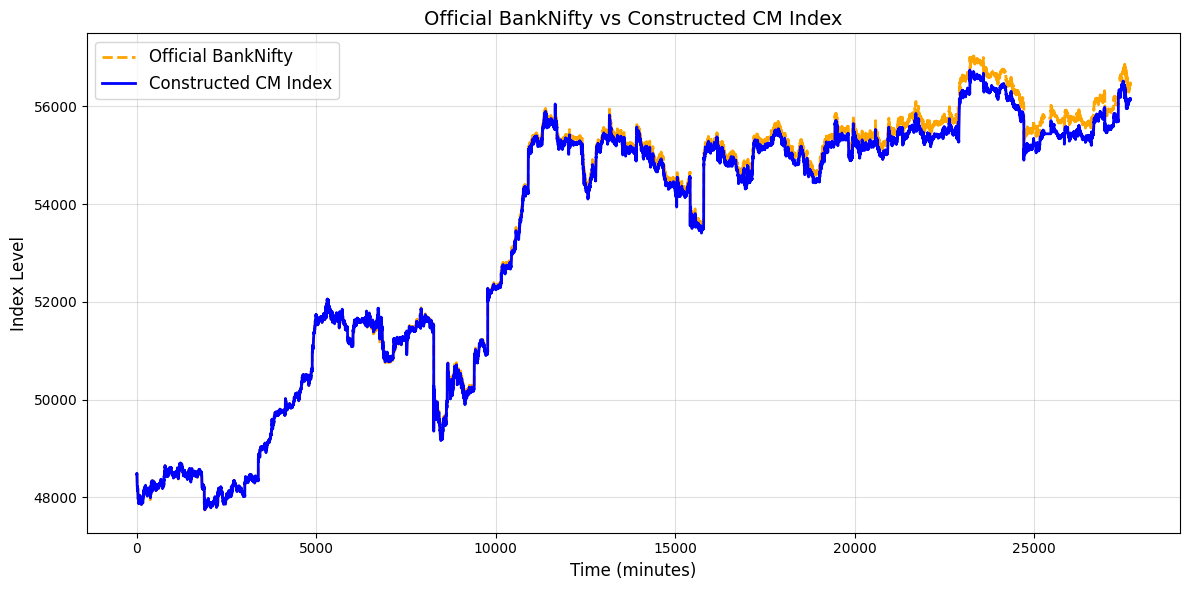

In [20]:
import matplotlib.pyplot as plt

out["bn_index"] = pd.to_numeric(out["bn_index"], errors="coerce")
out["bn_constructed_index"] = pd.to_numeric(out["bn_constructed_index"], errors="coerce")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(out["timestamp"], out["bn_index"], label="Official BankNifty", color="orange", linewidth=2, linestyle="--")
plt.plot(out["timestamp"], out["bn_constructed_index"], label="Constructed CM Index", color="blue", linewidth=2)

plt.title("Official BankNifty vs Constructed CM Index", fontsize=14)
plt.xlabel("Time (minutes)", fontsize=12)
plt.ylabel("Index Level", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
import numpy as np

# Load the file that contains both official and constructed indices
df = pd.read_csv("cm_index_te_min.csv")  # or "cm_index_mcap_weighted.csv"
df = df.dropna(subset=["bn_index", "bn_constructed_index"])

# Compute log returns 
df["ret_real"] = np.log(df["bn_index"] / df["bn_index"].shift(1))
df["ret_constructed"] = np.log(df["bn_constructed_index"] / df["bn_constructed_index"].shift(1))

# Drop first NaN row
df = df.dropna()

# ----- Compute metrics -----
def calc_metrics(series):
    mean_ret = series.mean()
    std_ret = series.std()
    total_ret = (np.exp(series.sum()) - 1) * 100   # total % return over the period
    sharpe = mean_ret / std_ret if std_ret != 0 else np.nan
    return total_ret, std_ret, sharpe

total_real, vol_real, sharpe_real = calc_metrics(df["ret_real"])
total_cm, vol_cm, sharpe_cm = calc_metrics(df["ret_constructed"])

# ----- Print summary -----
print("📈 PERFORMANCE COMPARISON (log-returns)")
print(f"{'Metric':<20}{'Official BN':>15}{'Constructed CM':>20}")
print("-" * 55)
print(f"{'Total Return (%)':<20}{total_real:>15.2f}{total_cm:>20.2f}")
print(f"{'Volatility (std)':<20}{vol_real:>15.5f}{vol_cm:>20.5f}")
print(f"{'Sharpe Ratio':<20}{sharpe_real:>15.3f}{sharpe_cm:>20.3f}")

# Optional: correlation check
corr = df["ret_real"].corr(df["ret_constructed"])
print(f"\nCorrelation of returns: {corr:.4f}")


📈 PERFORMANCE COMPARISON (log-returns)
Metric                  Official BN      Constructed CM
-------------------------------------------------------
Total Return (%)              16.51               15.81
Volatility (std)            0.00056             0.00057
Sharpe Ratio                  0.010               0.009

Correlation of returns: 0.9811
